## Zoloeva Alana, Ilaria Curzi, Georgia Zavou

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Loading data
test_A= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle project/test_A_derma.csv')
train_A= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle project/train_A_derma.csv')
train_B = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle project/train_B_text.csv')
test_B = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle project/test_B_text.csv')

In [ ]:
#Let's change the label for purposes of prediction
train_B['label'] = train_B['Fake/Real'].replace({'fake': 0, 'real': 1})
train_B = train_B.drop('Fake/Real',axis=1)
train_B

<ipython-input-5-2a981a4fa4ef>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_B['label'] = train_B['Fake/Real'].replace({'fake': 0, 'real': 1})


,Id,Title,label
0,0,Begin Again trailer with Keira Knighley VIDEO\n,1
1,1,San Diegans share what brightens their day on ...,1
2,2,Gold Prices Hit Five-Week Low Below $1300 an O...,0
3,3,Healthcare Innovation: Promising Vaccine in De...,0
4,4,Twitter Introduces Photo Tagging and Collage U...,0
...,...,...,...
2443,2443,Madonna to Adapt Rebecca Walker's Novella\n,0
2444,2444,Drew Barrymore Welcomes Second Baby!\n,1
2445,2445,[Weekend Poll] Are You Keeping Your Amazon Pri...,1
2446,2446,5 Reasons Why You'll Want To Workout In OMsign...,1


In [ ]:
train_B.shape

(2448, 3)

In [ ]:
train_B

,Id,Title,label
0,0,Begin Again trailer with Keira Knighley VIDEO\n,1
1,1,San Diegans share what brightens their day on ...,1
2,2,Gold Prices Hit Five-Week Low Below $1300 an O...,0
3,3,Healthcare Innovation: Promising Vaccine in De...,0
4,4,Twitter Introduces Photo Tagging and Collage U...,0
...,...,...,...
2443,2443,Madonna to Adapt Rebecca Walker's Novella\n,0
2444,2444,Drew Barrymore Welcomes Second Baby!\n,1
2445,2445,[Weekend Poll] Are You Keeping Your Amazon Pri...,1
2446,2446,5 Reasons Why You'll Want To Workout In OMsign...,1


In [ ]:
#there are no nan-values
train_B.isna().sum()

,0
Id,0
Title,0
Fake/Real,0


In [ ]:
train_B.shape, test_B.shape

((2448, 3), (1050, 2))

In [ ]:
print(train_B['label'].value_counts(normalize=True))
#the imbalance in data is not very high, 57% againt 43%, but it will be useful to consider during tuning of parameters

label
1    0.571895
0    0.428105
Name: proportion, dtype: float64


### Feature engineering

## Modelling

### Final model - some feature engineering added + TF-IDF + XGBoost

Normally, text cleaning rises the accuracy of prediction, but we noticed, that the "uncleaness" of the text such as punctuation, stopwords and different forms of words allows to understand whether the text is fake or real.
For example, using the lemmatization and eliminating stopwords dropped the accuracy to around 0.75.

In [ ]:
# Initial data
X = train_B['Title']
y = train_B['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining a function for feature extraction
def extract_features(df):
    stop_words = set(stopwords.words('english'))

    # Feature 1: Presence of Quotes
    df['Has_Quotes'] = df['Title'].str.contains('"').astype(int)

    # Feature 2: Title Length
    df['Title_Length'] = df['Title'].apply(len)

    # Feature 3: Number of Words
    df['Word_Count'] = df['Title'].str.split().apply(len)
    df['Unique_Word_Count'] = df['Title'].str.split().apply(lambda x: len(set(x)))

    # Feature 4: Number of Uppercase Characters
    df['Uppercase_Count'] = df['Title'].apply(lambda x: sum(1 for c in x if c.isupper()))

    # Feature 5: Average Word Length
    df['Avg_Word_Length'] = df['Title'].str.split().apply(lambda x: sum(len(word) for word in x) / len(x))

    # Feature 6: Number of Digits
    df['Digit_Count'] = df['Title'].apply(lambda x: sum(1 for c in x if c.isdigit()))

    # Feature 7: Number of Special Characters
    special_characters = r'[^A-Za-z0-9 ]'
    df['Special_Char_Count'] = df['Title'].str.count(special_characters)

    # Feature 8: Title in Uppercase
    df['Title_Uppercase'] = df['Title'].apply(lambda x: x.isupper()).astype(int)

    # Feature 9: Stop Words Count
    df['Stop_Word_Count'] = df['Title'].apply(lambda x: sum(1 for word in word_tokenize(x.lower()) if word in stop_words))

    return df

# Extracting features from training and test sets
X_train_new = extract_features(pd.DataFrame(X_train, columns=['Title']))
X_test_new = extract_features(pd.DataFrame(X_test, columns=['Title']))

# Text vectorization with tf idf
vectorizer = TfidfVectorizer(max_features=4000)
X_train_tfidf = vectorizer.fit_transform(X_train_new['Title'])
X_test_tfidf = vectorizer.transform(X_test_new['Title'])

X_subm_feat = extract_features(pd.DataFrame(test_B)).drop('Id', axis=1) # X_test is a df here
X_subm_tfidf = vectorizer.transform(X_subm_feat['Title'])

# Converting additional features to csr_matrix
additional_features_train = csr_matrix(X_train_new.drop(columns=['Title']).values)
additional_features_test = csr_matrix(X_test_new.drop(columns=['Title']).values)
additional_features_subm = X_subm_feat.drop('Title', axis=1).values

# Combining TF-IDF with other features for training and test sets
X_train_combined = hstack([X_train_tfidf, additional_features_train])
X_test_combined = hstack([X_test_tfidf, additional_features_test])
X_subm_combined = hstack([X_subm_tfidf, additional_features_subm])

# Training the XGBoost model
model = XGBClassifier(random_state=16, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_combined, y_train)

# Prediction and accuracy evaluation
y_pred = model.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:02:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8306


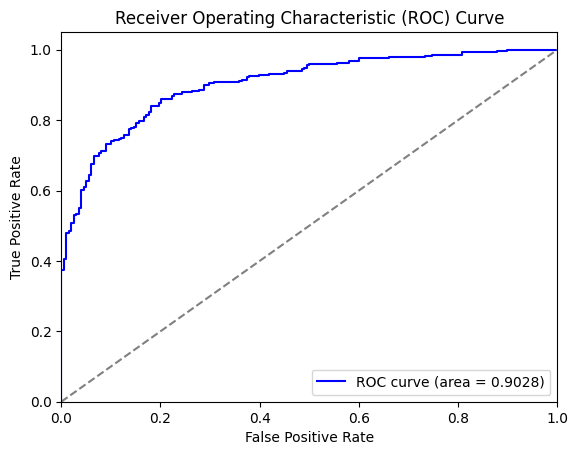

ROC AUC Score: 0.9028


In [26]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predicting probabilities for the positive class
y_proba = model.predict_proba(X_test_combined)[:, 1]

# Calculating ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f'ROC AUC Score: {roc_auc:.4f}')


ROC AUC score looks good for the model

In [20]:
# Parameters for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, 2, 3, 4],  # Parameter for class balancing
    # 'subsample': [0.7, 0.8, 1.0],
    # 'colsample_bytree': [0.7, 0.8, 1.0]
}

# Initializing the model and GridSearchCV
xgb_model = XGBClassifier(random_state=16, use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Training GridSearchCV
grid_search.fit(X_train_combined, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Training the model with the best parameters
best_model = XGBClassifier(random_state=16, use_label_encoder=False, eval_metric='logloss', **best_params)
best_model.fit(X_train_combined, y_train)

# Evaluation on the test set
y_pred = best_model.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set: {accuracy:.4f}')

# Classification report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

We see that the model didn't become better after tuning the hyperparameters, so we will use the initial ones

### Preparing the predictions for submission

In [ ]:
y_subm = model.predict(X_subm_combined)

In [ ]:
test_B_subm = test_B.copy()
test_B_subm['Prediction'] = y_subm
test_B_subm = test_B_subm.drop('Title',axis=1)
test_B_subm['Prediction'] = test_B_subm['Prediction'].replace({0:'fake', 1:'real'})


In [ ]:
test_B_subm.to_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle project/submission_B.csv', index=False)

In [ ]:
test_B_subm

,Id,Prediction
0,0,fake
1,1,real
2,2,real
3,3,fake
4,4,real
...,...,...
1045,1045,real
1046,1046,fake
1047,1047,real
1048,1048,real


In [ ]:
test_A_subm = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle project/submission_A.csv')
final = pd.concat([test_A_subm,test_B_subm],axis=0)
final['Id'] = range(0, len(final))
final.to_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle project/final.csv', index=False)

### Unsuccessful attempts - just to see

#### TF-idf + Logistic regression

In [ ]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.3 MB/s eta 0:00:00


In [ ]:
import textstat
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack

# Sample data
X = train_B['Title']
y = train_B['label']

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculating lexical complexity for each text
X_train_lexical_complexity = X_train.apply(lambda text: textstat.flesch_reading_ease(text))
X_test_lexical_complexity = X_test.apply(lambda text: textstat.flesch_reading_ease(text))

# Text vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Adding lexical complexity score as a new column
X_train_features = hstack([X_train_tfidf, X_train_lexical_complexity.values.reshape(-1, 1)])
X_test_features = hstack([X_test_tfidf, X_test_lexical_complexity.values.reshape(-1, 1)])

# Logistic regression model
model = LogisticRegression(random_state=16)

# Training the model
model.fit(X_train_features, y_train)

# Prediction and accuracy evaluation
y_pred = model.predict(X_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.7061


In [ ]:
!pip install lexicalrichness

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lexicalrichness: filename=lexicalrichness-0.5.1-py3-none-any.whl size=15415 sha256=6394a9eddd492ce629237064c6933f7663a7271d4fccb03629bca9535ce59a18
  Stored in directory: /root/.cache/pip/wheels/cd/ba/80/d4dabc1bf242a672ffc00226a2303a7471bb841c0872b2c212
Successfully built lexicalrichness


In [ ]:
import textstat
from lexicalrichness import LexicalRichness
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack
import numpy as np

# Sample data
X = train_B['Title']
y = train_B['label']

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculating various lexical complexity metrics for each text
def compute_lexical_complexity(text):
    complexity_features = {
        'flesch': textstat.flesch_reading_ease(text),
        'dale_chall': textstat.dale_chall_readability_score(text),
        'smog': textstat.smog_index(text),
        'lexical_richness': LexicalRichness(text).ttr  # Type-Token Ratio for lexical diversity
    }
    return complexity_features

X_train_complexity = X_train.apply(compute_lexical_complexity).apply(pd.Series)
X_test_complexity = X_test.apply(compute_lexical_complexity).apply(pd.Series)

# Text vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Converting complexity metrics to a matrix and adding them as new features
X_train_complexity_matrix = np.array(X_train_complexity)
X_test_complexity_matrix = np.array(X_test_complexity)

X_train_features = hstack([X_train_tfidf, X_train_complexity_matrix])
X_test_features = hstack([X_test_tfidf, X_test_complexity_matrix])

# Logistic regression model
model = LogisticRegression(random_state=16)

# Training the model
model.fit(X_train_features, y_train)

# Prediction and accuracy evaluation
y_pred = model.predict(X_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.7122


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### TF-IDF + Logreg + Text emotionality

In [ ]:
# Let's add one more feature - the length of the text
train_B['title_length'] = train_B['Title'].apply(len)

# Now let's add another feature: text emotionality. Human-made text may be more emotional
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

train_B['sentiment'] = train_B['Title'].apply(get_sentiment)


X_text = train_B['Title']
X_length = train_B['title_length']
X_sentiment = train_B['sentiment']
y = train_B['label']


X_text_train, X_text_test, X_length_train, X_length_test, X_sentiment_train, X_sentiment_test, y_train, y_test = train_test_split(
    X_text, X_length, X_sentiment, y, test_size=0.2, random_state=42
)

# Vectorizing the text
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_text_train)
X_test_tfidf = vectorizer.transform(X_text_test)

# Adjusting the shape of data
X_train_full = pd.DataFrame.sparse.from_spmatrix(X_train_tfidf)
X_train_full['length'] = X_length_train.values
X_train_full['sentiment'] = X_sentiment_train.values

X_test_full = pd.DataFrame.sparse.from_spmatrix(X_test_tfidf)
X_test_full['length'] = X_length_test.values
X_test_full['sentiment'] = X_sentiment_test.values

#Converting column names to string
X_train_full.columns = X_train_full.columns.astype(str)
X_test_full.columns = X_test_full.columns.astype(str)


model = LogisticRegression()

model.fit(X_train_full, y_train)

y_pred = model.predict(X_test_full)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.7265


In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
#Let's tune hyperparameters of the model

warnings.filterwarnings("ignore")

param_grid = {'C': [0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_full, y_train)

print(f'Best parameters: {grid.best_params_}')
best_model = grid.best_estimator_


y_pred_best = best_model.predict(X_test_full)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Best Model Accuracy: {accuracy_best:.4f}')


Best parameters: {'C': 100, 'solver': 'lbfgs'}
Best Model Accuracy: 0.7245


#### TF-IDF + Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")


model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_features, y_train)


y_pred_rf = model_rf.predict(X_test_features)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.4f}')


Random Forest Accuracy: 0.7429


In [ ]:
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")


model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_full, y_train)


y_pred_rf = model_rf.predict(X_test_full)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.4f}')


Random Forest Accuracy: 0.7490


Best Test Accuracy: 0.7020 with params: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best Training Accuracy: 0.7809 with params: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [ ]:
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Disable warnings
warnings.filterwarnings("ignore")

# Step 1: Define the parameter grid for RandomForest
param_grid = {
    'n_estimators': [100, 300, 500],               # Number of trees
    'max_depth': [20, 30, 50],                     # Maximum depth of the tree
    'min_samples_split': [10, 15, 20],             # Minimum samples required to split a node
    'min_samples_leaf': [2, 5, 7],                 # Minimum samples required in a leaf
    'max_features': ['sqrt', 'log2']               # Number of features to consider at each split
}

# Create a RandomForestClassifier object
model_rf = RandomForestClassifier(random_state=42)

# Generate all possible combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))

# Initialize variables to store the best accuracy and parameters
best_test_accuracy = 0
best_train_accuracy = 0
best_params_test = None
best_params_train = None

# Iterate over each combination of parameters and output accuracy after fitting
for params in tqdm(param_combinations):
    # Set parameters for the model
    model_rf.set_params(**params)

    # Train the model
    model_rf.fit(X_train_features, y_train)

    # Predictions on the training set
    y_train_pred = model_rf.predict(X_train_features)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Predictions on the test set
    y_test_pred = model_rf.predict(X_test_features)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Output current accuracy
    print(f"Params: {params}")
    print(f"Training accuracy: {train_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")

    # Check and save the best accuracy for the test set
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_params_test = params

    # Check and save the best accuracy for the training set
    if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
        best_params_train = params

# Output the best accuracy and parameters
print(f"\nBest Test Accuracy: {best_test_accuracy:.4f} with params: {best_params_test}")
print(f"Best Training Accuracy: {best_train_accuracy:.4f} with params: {best_params_train}")


  1%|          | 1/162 [00:01<02:58,  1.11s/it]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.7441
Test accuracy: 0.6735


  1%|          | 2/162 [00:01<02:32,  1.05it/s]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Training accuracy: 0.7457
Test accuracy: 0.6878


  2%|▏         | 3/162 [00:03<03:03,  1.16s/it]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Training accuracy: 0.7446
Test accuracy: 0.6837


  2%|▏         | 4/162 [00:03<02:09,  1.22it/s]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 100}
Training accuracy: 0.7462
Test accuracy: 0.6694


  3%|▎         | 5/162 [00:04<02:26,  1.07it/s]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 300}
Training accuracy: 0.7457
Test accuracy: 0.6837


  4%|▎         | 6/162 [00:06<02:58,  1.15s/it]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 500}
Training accuracy: 0.7467
Test accuracy: 0.6837


  4%|▍         | 7/162 [00:06<02:13,  1.16it/s]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}
Training accuracy: 0.7451
Test accuracy: 0.6714


  5%|▍         | 8/162 [00:07<02:11,  1.17it/s]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 300}
Training accuracy: 0.7451
Test accuracy: 0.6898


  6%|▌         | 9/162 [00:08<02:34,  1.01s/it]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 500}
Training accuracy: 0.7472
Test accuracy: 0.6857


  6%|▌         | 10/162 [00:09<01:58,  1.28it/s]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.7242
Test accuracy: 0.6714


  7%|▋         | 11/162 [00:09<01:57,  1.29it/s]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 300}
Training accuracy: 0.7237
Test accuracy: 0.6918


  7%|▋         | 12/162 [00:11<02:32,  1.02s/it]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
Training accuracy: 0.7171
Test accuracy: 0.6796


  8%|▊         | 13/162 [00:11<02:03,  1.21it/s]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 100}
Training accuracy: 0.7252
Test accuracy: 0.6673


  9%|▊         | 14/162 [00:14<03:12,  1.30s/it]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 300}
Training accuracy: 0.7227
Test accuracy: 0.6939


  9%|▉         | 15/162 [00:16<03:37,  1.48s/it]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 500}
Training accuracy: 0.7160
Test accuracy: 0.6816


 10%|▉         | 16/162 [00:16<02:50,  1.17s/it]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
Training accuracy: 0.7232
Test accuracy: 0.6653


 10%|█         | 17/162 [00:17<02:32,  1.05s/it]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 300}
Training accuracy: 0.7232
Test accuracy: 0.6918


 11%|█         | 18/162 [00:18<02:39,  1.11s/it]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 500}
Training accuracy: 0.7155
Test accuracy: 0.6776


 12%|█▏        | 19/162 [00:18<02:01,  1.18it/s]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.6645
Test accuracy: 0.6490


 12%|█▏        | 20/162 [00:19<01:52,  1.26it/s]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 300}
Training accuracy: 0.6655
Test accuracy: 0.6510


 13%|█▎        | 21/162 [00:20<02:05,  1.12it/s]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 500}
Training accuracy: 0.6599
Test accuracy: 0.6429


 14%|█▎        | 22/162 [00:20<01:37,  1.44it/s]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 100}
Training accuracy: 0.6645
Test accuracy: 0.6490


 14%|█▍        | 23/162 [00:21<01:35,  1.46it/s]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 300}
Training accuracy: 0.6650
Test accuracy: 0.6490


 15%|█▍        | 24/162 [00:22<01:51,  1.24it/s]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 500}
Training accuracy: 0.6599
Test accuracy: 0.6429


 15%|█▌        | 25/162 [00:22<01:27,  1.56it/s]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 100}
Training accuracy: 0.6655
Test accuracy: 0.6490


 16%|█▌        | 26/162 [00:23<01:27,  1.55it/s]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 300}
Training accuracy: 0.6650
Test accuracy: 0.6490


 17%|█▋        | 27/162 [00:24<01:45,  1.28it/s]

Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 500}
Training accuracy: 0.6599
Test accuracy: 0.6429


 17%|█▋        | 28/162 [00:24<01:21,  1.64it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.6118
Test accuracy: 0.6204


 18%|█▊        | 29/162 [00:25<01:24,  1.57it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Training accuracy: 0.5930
Test accuracy: 0.6061


 19%|█▊        | 30/162 [00:27<02:05,  1.05it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Training accuracy: 0.5904
Test accuracy: 0.6082


 19%|█▉        | 31/162 [00:27<01:40,  1.30it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 100}
Training accuracy: 0.6118
Test accuracy: 0.6204


 20%|█▉        | 32/162 [00:28<01:51,  1.17it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 300}
Training accuracy: 0.5940
Test accuracy: 0.6061


 20%|██        | 33/162 [00:30<02:22,  1.11s/it]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 500}
Training accuracy: 0.5899
Test accuracy: 0.6082


 21%|██        | 34/162 [00:30<01:52,  1.14it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}
Training accuracy: 0.6118
Test accuracy: 0.6204


 22%|██▏       | 35/162 [00:31<01:48,  1.17it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 300}
Training accuracy: 0.5940
Test accuracy: 0.6061


 23%|██▎       | 37/162 [00:32<01:25,  1.47it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 500}
Training accuracy: 0.5899
Test accuracy: 0.6082
Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.5659
Test accuracy: 0.5959


 23%|██▎       | 38/162 [00:33<01:18,  1.57it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 300}
Training accuracy: 0.5659
Test accuracy: 0.5959


 25%|██▍       | 40/162 [00:34<01:06,  1.83it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
Training accuracy: 0.5659
Test accuracy: 0.5959
Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 100}
Training accuracy: 0.5659
Test accuracy: 0.5959


 25%|██▌       | 41/162 [00:34<01:05,  1.85it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 300}
Training accuracy: 0.5659
Test accuracy: 0.5959


 27%|██▋       | 43/162 [00:35<00:59,  2.00it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 500}
Training accuracy: 0.5659
Test accuracy: 0.5959
Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
Training accuracy: 0.5659
Test accuracy: 0.5959


 27%|██▋       | 44/162 [00:36<01:01,  1.93it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 300}
Training accuracy: 0.5659
Test accuracy: 0.5959


 28%|██▊       | 46/162 [00:37<00:56,  2.05it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 500}
Training accuracy: 0.5659
Test accuracy: 0.5959
Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.5659
Test accuracy: 0.5959


 29%|██▉       | 47/162 [00:37<00:57,  2.00it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 300}
Training accuracy: 0.5659
Test accuracy: 0.5959


 30%|███       | 49/162 [00:38<00:53,  2.10it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 500}
Training accuracy: 0.5659
Test accuracy: 0.5959
Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 100}
Training accuracy: 0.5659
Test accuracy: 0.5959


 31%|███       | 50/162 [00:39<00:56,  2.00it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 300}
Training accuracy: 0.5659
Test accuracy: 0.5959


 32%|███▏      | 52/162 [00:40<01:01,  1.79it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 500}
Training accuracy: 0.5659
Test accuracy: 0.5959
Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 100}
Training accuracy: 0.5659
Test accuracy: 0.5959


 33%|███▎      | 53/162 [00:41<01:06,  1.64it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 300}
Training accuracy: 0.5659
Test accuracy: 0.5959


 33%|███▎      | 54/162 [00:42<01:30,  1.20it/s]

Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 500}
Training accuracy: 0.5659
Test accuracy: 0.5959


 34%|███▍      | 55/162 [00:43<01:19,  1.34it/s]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.7835
Test accuracy: 0.6939


 35%|███▍      | 56/162 [00:45<01:45,  1.00it/s]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Training accuracy: 0.7829
Test accuracy: 0.6980


 35%|███▌      | 57/162 [00:47<02:15,  1.29s/it]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Training accuracy: 0.7886
Test accuracy: 0.7041


 36%|███▌      | 58/162 [00:47<01:44,  1.00s/it]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 100}
Training accuracy: 0.7829
Test accuracy: 0.7020


 36%|███▋      | 59/162 [00:48<01:42,  1.00it/s]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 300}
Training accuracy: 0.7814
Test accuracy: 0.6918


 37%|███▋      | 60/162 [00:49<02:00,  1.19s/it]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 500}
Training accuracy: 0.7896
Test accuracy: 0.7041


 38%|███▊      | 61/162 [00:50<01:34,  1.07it/s]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}
Training accuracy: 0.7835
Test accuracy: 0.7020


 38%|███▊      | 62/162 [00:51<01:39,  1.00it/s]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 300}
Training accuracy: 0.7773
Test accuracy: 0.6959


 39%|███▉      | 63/162 [00:53<02:04,  1.26s/it]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 500}
Training accuracy: 0.7896
Test accuracy: 0.7000


 40%|███▉      | 64/162 [00:53<01:34,  1.03it/s]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.7523
Test accuracy: 0.6959


 40%|████      | 65/162 [00:54<01:30,  1.08it/s]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 300}
Training accuracy: 0.7380
Test accuracy: 0.6980


 41%|████      | 66/162 [00:55<01:41,  1.06s/it]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
Training accuracy: 0.7451
Test accuracy: 0.7020


 41%|████▏     | 67/162 [00:56<01:22,  1.15it/s]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 100}
Training accuracy: 0.7457
Test accuracy: 0.6939


 42%|████▏     | 68/162 [00:57<01:33,  1.01it/s]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 300}
Training accuracy: 0.7380
Test accuracy: 0.6980


 43%|████▎     | 69/162 [00:59<02:04,  1.34s/it]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 500}
Training accuracy: 0.7431
Test accuracy: 0.7020


 43%|████▎     | 70/162 [01:00<01:38,  1.07s/it]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
Training accuracy: 0.7446
Test accuracy: 0.6959


 44%|████▍     | 71/162 [01:01<01:38,  1.08s/it]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 300}
Training accuracy: 0.7380
Test accuracy: 0.7020


 44%|████▍     | 72/162 [01:02<01:45,  1.18s/it]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 500}
Training accuracy: 0.7436
Test accuracy: 0.7020


 45%|████▌     | 73/162 [01:03<01:23,  1.07it/s]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.6828
Test accuracy: 0.6653


 46%|████▌     | 74/162 [01:03<01:21,  1.08it/s]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 300}
Training accuracy: 0.6762
Test accuracy: 0.6551


 46%|████▋     | 75/162 [01:05<01:25,  1.02it/s]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 500}
Training accuracy: 0.6660
Test accuracy: 0.6531


 47%|████▋     | 76/162 [01:05<01:05,  1.32it/s]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 100}
Training accuracy: 0.6828
Test accuracy: 0.6653


 48%|████▊     | 77/162 [01:05<01:02,  1.36it/s]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 300}
Training accuracy: 0.6757
Test accuracy: 0.6551


 48%|████▊     | 78/162 [01:07<01:12,  1.16it/s]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 500}
Training accuracy: 0.6650
Test accuracy: 0.6531


 49%|████▉     | 79/162 [01:07<00:56,  1.48it/s]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 100}
Training accuracy: 0.6828
Test accuracy: 0.6653


 49%|████▉     | 80/162 [01:08<00:55,  1.48it/s]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 300}
Training accuracy: 0.6757
Test accuracy: 0.6551


 50%|█████     | 81/162 [01:09<01:05,  1.24it/s]

Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 500}
Training accuracy: 0.6639
Test accuracy: 0.6531


 51%|█████     | 82/162 [01:09<00:50,  1.58it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.6374
Test accuracy: 0.6347


 51%|█████     | 83/162 [01:10<00:50,  1.56it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Training accuracy: 0.6261
Test accuracy: 0.6204


 52%|█████▏    | 84/162 [01:11<01:04,  1.21it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Training accuracy: 0.6323
Test accuracy: 0.6204


 52%|█████▏    | 85/162 [01:11<00:52,  1.46it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 100}
Training accuracy: 0.6369
Test accuracy: 0.6327


 53%|█████▎    | 86/162 [01:12<01:00,  1.26it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 300}
Training accuracy: 0.6256
Test accuracy: 0.6204


 54%|█████▎    | 87/162 [01:14<01:22,  1.10s/it]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 500}
Training accuracy: 0.6318
Test accuracy: 0.6204


 54%|█████▍    | 88/162 [01:14<01:06,  1.12it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}
Training accuracy: 0.6384
Test accuracy: 0.6327


 55%|█████▍    | 89/162 [01:16<01:11,  1.01it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 300}
Training accuracy: 0.6251
Test accuracy: 0.6204


 56%|█████▌    | 91/162 [01:17<00:56,  1.26it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 500}
Training accuracy: 0.6323
Test accuracy: 0.6204
Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.5659
Test accuracy: 0.5959


 57%|█████▋    | 92/162 [01:18<00:49,  1.41it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 300}
Training accuracy: 0.5659
Test accuracy: 0.5959


 58%|█████▊    | 94/162 [01:19<00:40,  1.70it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
Training accuracy: 0.5659
Test accuracy: 0.5959
Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 100}
Training accuracy: 0.5659
Test accuracy: 0.5959


 59%|█████▊    | 95/162 [01:19<00:38,  1.75it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 300}
Training accuracy: 0.5659
Test accuracy: 0.5959


 60%|█████▉    | 97/162 [01:20<00:33,  1.94it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 500}
Training accuracy: 0.5659
Test accuracy: 0.5959
Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
Training accuracy: 0.5659
Test accuracy: 0.5959


 60%|██████    | 98/162 [01:21<00:33,  1.92it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 300}
Training accuracy: 0.5659
Test accuracy: 0.5959


 62%|██████▏   | 100/162 [01:22<00:30,  2.02it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 500}
Training accuracy: 0.5659
Test accuracy: 0.5959
Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.5659
Test accuracy: 0.5959


 62%|██████▏   | 101/162 [01:22<00:30,  1.99it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 300}
Training accuracy: 0.5659
Test accuracy: 0.5959


 64%|██████▎   | 103/162 [01:23<00:28,  2.08it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 500}
Training accuracy: 0.5659
Test accuracy: 0.5959
Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 100}
Training accuracy: 0.5659
Test accuracy: 0.5959


 64%|██████▍   | 104/162 [01:24<00:28,  2.02it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 300}
Training accuracy: 0.5659
Test accuracy: 0.5959


 65%|██████▌   | 106/162 [01:25<00:26,  2.08it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 500}
Training accuracy: 0.5659
Test accuracy: 0.5959
Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 100}
Training accuracy: 0.5659
Test accuracy: 0.5959


 66%|██████▌   | 107/162 [01:25<00:27,  2.03it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 300}
Training accuracy: 0.5659
Test accuracy: 0.5959


 67%|██████▋   | 108/162 [01:27<00:38,  1.39it/s]

Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 500}
Training accuracy: 0.5659
Test accuracy: 0.5959


 67%|██████▋   | 109/162 [01:27<00:37,  1.40it/s]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.8340
Test accuracy: 0.7184


 68%|██████▊   | 110/162 [01:29<00:57,  1.10s/it]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Training accuracy: 0.8412
Test accuracy: 0.7184


 69%|██████▊   | 111/162 [01:32<01:24,  1.66s/it]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Training accuracy: 0.8422
Test accuracy: 0.7184


 69%|██████▉   | 112/162 [01:33<01:04,  1.29s/it]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 100}
Training accuracy: 0.8366
Test accuracy: 0.7204


 70%|██████▉   | 113/162 [01:34<01:03,  1.29s/it]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 300}
Training accuracy: 0.8417
Test accuracy: 0.7184


 70%|███████   | 114/162 [01:36<01:14,  1.55s/it]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 500}
Training accuracy: 0.8437
Test accuracy: 0.7204


 71%|███████   | 115/162 [01:37<00:57,  1.22s/it]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}
Training accuracy: 0.8335
Test accuracy: 0.7265


 72%|███████▏  | 116/162 [01:38<00:56,  1.23s/it]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 300}
Training accuracy: 0.8391
Test accuracy: 0.7184


 72%|███████▏  | 117/162 [01:40<01:11,  1.59s/it]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 500}
Training accuracy: 0.8412
Test accuracy: 0.7184


 73%|███████▎  | 118/162 [01:41<00:53,  1.21s/it]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.7559
Test accuracy: 0.6980


 73%|███████▎  | 119/162 [01:42<00:48,  1.12s/it]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 300}
Training accuracy: 0.7574
Test accuracy: 0.7000


 74%|███████▍  | 120/162 [01:44<01:00,  1.45s/it]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
Training accuracy: 0.7589
Test accuracy: 0.6980


 75%|███████▍  | 121/162 [01:44<00:47,  1.15s/it]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 100}
Training accuracy: 0.7543
Test accuracy: 0.7000


 75%|███████▌  | 122/162 [01:46<00:48,  1.22s/it]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 300}
Training accuracy: 0.7569
Test accuracy: 0.7020


 76%|███████▌  | 123/162 [01:48<01:06,  1.69s/it]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 500}
Training accuracy: 0.7594
Test accuracy: 0.6980


 77%|███████▋  | 124/162 [01:49<00:48,  1.28s/it]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
Training accuracy: 0.7528
Test accuracy: 0.7000


 77%|███████▋  | 125/162 [01:50<00:43,  1.16s/it]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 300}
Training accuracy: 0.7574
Test accuracy: 0.7000


 78%|███████▊  | 126/162 [01:51<00:48,  1.36s/it]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 500}
Training accuracy: 0.7574
Test accuracy: 0.6959


 78%|███████▊  | 127/162 [01:52<00:35,  1.02s/it]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.6839
Test accuracy: 0.6653


 79%|███████▉  | 128/162 [01:52<00:31,  1.09it/s]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 300}
Training accuracy: 0.6772
Test accuracy: 0.6551


 80%|███████▉  | 129/162 [01:53<00:32,  1.02it/s]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 500}
Training accuracy: 0.6670
Test accuracy: 0.6551


 80%|████████  | 130/162 [01:54<00:24,  1.32it/s]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 100}
Training accuracy: 0.6839
Test accuracy: 0.6653


 81%|████████  | 131/162 [01:54<00:22,  1.36it/s]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 300}
Training accuracy: 0.6772
Test accuracy: 0.6551


 81%|████████▏ | 132/162 [01:56<00:25,  1.17it/s]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 500}
Training accuracy: 0.6670
Test accuracy: 0.6551


 82%|████████▏ | 133/162 [01:56<00:19,  1.50it/s]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 100}
Training accuracy: 0.6839
Test accuracy: 0.6653


 83%|████████▎ | 134/162 [01:56<00:18,  1.48it/s]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 300}
Training accuracy: 0.6772
Test accuracy: 0.6551


 83%|████████▎ | 135/162 [01:58<00:26,  1.04it/s]

Params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 500}
Training accuracy: 0.6660
Test accuracy: 0.6551


 84%|████████▍ | 136/162 [01:59<00:20,  1.25it/s]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.6701
Test accuracy: 0.6429


 85%|████████▍ | 137/162 [02:01<00:31,  1.25s/it]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Training accuracy: 0.6839
Test accuracy: 0.6347


 85%|████████▌ | 138/162 [02:03<00:35,  1.48s/it]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Training accuracy: 0.6885
Test accuracy: 0.6327


 86%|████████▌ | 139/162 [02:03<00:25,  1.11s/it]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 100}
Training accuracy: 0.6696
Test accuracy: 0.6429


 86%|████████▋ | 140/162 [02:04<00:21,  1.01it/s]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 300}
Training accuracy: 0.6834
Test accuracy: 0.6347


 87%|████████▋ | 141/162 [02:05<00:21,  1.04s/it]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 500}
Training accuracy: 0.6885
Test accuracy: 0.6327


 88%|████████▊ | 142/162 [02:05<00:15,  1.25it/s]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}
Training accuracy: 0.6696
Test accuracy: 0.6429


 88%|████████▊ | 143/162 [02:06<00:14,  1.29it/s]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 300}
Training accuracy: 0.6859
Test accuracy: 0.6367


 90%|████████▉ | 145/162 [02:07<00:11,  1.47it/s]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 500}
Training accuracy: 0.6874
Test accuracy: 0.6327
Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.5659
Test accuracy: 0.5959


 90%|█████████ | 146/162 [02:08<00:10,  1.57it/s]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 300}
Training accuracy: 0.5659
Test accuracy: 0.5959


 91%|█████████▏| 148/162 [02:09<00:07,  1.82it/s]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
Training accuracy: 0.5659
Test accuracy: 0.5959
Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 100}
Training accuracy: 0.5659
Test accuracy: 0.5959


 92%|█████████▏| 149/162 [02:09<00:07,  1.84it/s]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 300}
Training accuracy: 0.5659
Test accuracy: 0.5959


 93%|█████████▎| 151/162 [02:10<00:05,  1.98it/s]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 500}
Training accuracy: 0.5659
Test accuracy: 0.5959
Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
Training accuracy: 0.5659
Test accuracy: 0.5959


 94%|█████████▍| 152/162 [02:11<00:05,  1.94it/s]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 300}
Training accuracy: 0.5659
Test accuracy: 0.5959


 95%|█████████▌| 154/162 [02:12<00:03,  2.04it/s]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 500}
Training accuracy: 0.5659
Test accuracy: 0.5959
Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.5659
Test accuracy: 0.5959


 96%|█████████▌| 155/162 [02:13<00:04,  1.68it/s]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 300}
Training accuracy: 0.5659
Test accuracy: 0.5959


 96%|█████████▋| 156/162 [02:14<00:05,  1.11it/s]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 500}
Training accuracy: 0.5659
Test accuracy: 0.5959


 97%|█████████▋| 157/162 [02:15<00:03,  1.38it/s]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 100}
Training accuracy: 0.5659
Test accuracy: 0.5959


 98%|█████████▊| 158/162 [02:16<00:03,  1.31it/s]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 300}
Training accuracy: 0.5659
Test accuracy: 0.5959


 98%|█████████▊| 159/162 [02:17<00:02,  1.04it/s]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 500}
Training accuracy: 0.5659
Test accuracy: 0.5959


 99%|█████████▉| 160/162 [02:17<00:01,  1.31it/s]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 100}
Training accuracy: 0.5659
Test accuracy: 0.5959


 99%|█████████▉| 161/162 [02:18<00:00,  1.34it/s]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 300}
Training accuracy: 0.5659
Test accuracy: 0.5959


100%|██████████| 162/162 [02:19<00:00,  1.16it/s]

Params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 500}
Training accuracy: 0.5659
Test accuracy: 0.5959

Best Test Accuracy: 0.7265 with params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}
Best Training Accuracy: 0.8437 with params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 500}


#### TF-IDF + XGBoost, TF-idf + SVC

In [ ]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# SVM
model_svm = SVC()
model_svm.fit(X_train_tfidf, y_train)
y_pred_svm = model_svm.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm:.4f}')

# XGBoost
model_xgb = XGBClassifier()
model_xgb.fit(X_train_tfidf, y_train)
y_pred_xgb = model_xgb.predict(X_test_tfidf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {accuracy_xgb:.4f}')


SVM Accuracy: 0.7673
XGBoost Accuracy: 0.7000


#### SVC tuning

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Model initialization
model_svm = SVC()

# Defining the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],                  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],     # Kernel type
    'gamma': ['scale', 'auto']               # Kernel coefficient
}

# Setting up GridSearchCV
grid_search = GridSearchCV(
    estimator=model_svm,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=4
)

# Training the model on the training set
grid_search.fit(X_train_tfidf, y_train)

# Getting the best parameters and evaluating on the test set
best_model_svm = grid_search.best_estimator_
y_pred_svm = best_model_svm.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Accuracy с лучшими параметрами: 0.7592


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Model initialization
model_svm = SVC()

# Updated hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 50, 100],             # Extended range for regularization
    'kernel': ['linear', 'rbf'],            # Keeping the most reliable kernels
    'gamma': ['scale', 'auto', 0.01, 0.1, 1] # Adding gamma values
}

# Setting up GridSearchCV
grid_search = GridSearchCV(
    estimator=model_svm,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=4
)

# Training the model on the training set
grid_search.fit(X_train_tfidf, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 50, 100],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=4)

In [ ]:
best_model_svm = grid_search.best_estimator_
y_pred_svm = best_model_svm.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f'Best params: {grid_search.best_params_}')
print(f'SVM Accuracy with best params: {accuracy_svm:.4f}')

Лучшие параметры: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Accuracy с лучшими параметрами: 0.7592
